# Instrucciones

Requisitos: debemos tener en nuestro Google Drive la carpeta `demo_orla` y, dentro, el archivo `alumnos.zip` y el fichero `tiltnet18.pkl` generado por el cuaderno anterior.

1. Menú Entorno de ejecucion -> Cambiar tipo de entorno de ejecución -> Acelerador por hardware: GPU

2. Entorno de ejecución -> Ejecutar todas

3. En la celda nº 6 nos pedirá abrir un enlace e introducir el código de autorización para que el cuaderno pueda acceder a nuestro Google Drive.

# Preparativos
- Instalamos la librería `fastai` y la utilidad `gdown` para descargar archivos de Google Drive
- Descargamos la librería de detección facial S3FD: https://github.com/jamarju/face-detection-pytorch y la red pre-entrenada
- Descargamos la librería de eliminación de fondo MODNet: https://github.com/ZHKKKe/MODNet y la red pre-entrenada

In [1]:
!pip install -U fastai gdown

In [2]:
!git clone https://github.com/jamarju/face-detection-pytorch
!mv face-detection-pytorch/detectors .
!mv face-detection-pytorch/utils .
!mkdir face-detection-pytorch/detectors/s3fd/weights
!gdown --id 1ktVh55p-Ynu6LonSyZtaUJxU23BS0Pdk -O detectors/s3fd/weights/sfd_face.pth

fatal: destination path 'face-detection-pytorch' already exists and is not an empty directory.
mv: cannot stat 'face-detection-pytorch/detectors': No such file or directory
mv: cannot stat 'face-detection-pytorch/utils': No such file or directory
mkdir: cannot create directory ‘face-detection-pytorch/detectors/s3fd/weights’: No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1ktVh55p-Ynu6LonSyZtaUJxU23BS0Pdk
To: /space/ml/demo_orla/detectors/s3fd/weights/sfd_face.pth
89.8MB [00:01, 60.1MB/s]


In [3]:
!git clone https://github.com/ZHKKKe/MODNet
!gdown https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz -O MODNet/pretrained/modnet_photographic_portrait_matting.ckpt

fatal: destination path 'MODNet' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /space/ml/demo_orla/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
26.3MB [00:00, 36.8MB/s]


In [4]:
from pathlib import Path
from zipfile import ZipFile
import shutil
import sys

from fastai.basics import *
from fastai.vision.all import *
from fastai.distributed import *
from tqdm.notebook import tqdm

from detectors import S3FD
from utils.bbox import draw_bboxes, crop_thumbnail


In [5]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [6]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_d = Path('/content/drive')
else:
    data_d = Path('data')

In [7]:
temp_d = Path('temp')
temp_d.mkdir(exist_ok=True)

In [8]:
%%time
if not (temp_d / 'alumnos').exists():
    with ZipFile(data_d / 'alumnos.zip', 'r') as z:
        z.extractall('temp')

CPU times: user 10 µs, sys: 17 µs, total: 27 µs
Wall time: 27.4 µs


In [9]:
alus_d = temp_d / 'alumnos'

In [10]:
alus_d.ls()

(#9) [Path('temp/alumnos/BARTOLOME MARÍ.jpg'),Path('temp/alumnos/LEONARDO DICAPRIO.jpg'),Path('temp/alumnos/NAROA BAÑOS.jpg'),Path('temp/alumnos/ORIOL CORRAL.jpg'),Path('temp/alumnos/CLINT EASTWOOD.jpg'),Path('temp/alumnos/ISABEL CAMARA.jpg'),Path('temp/alumnos/JUAN ESPAÑOL ESPAÑOL.jpg'),Path('temp/alumnos/HERMINIO MONGE.jpg'),Path('temp/alumnos/LUCIANO ATIENZA.jpg')]

# Paso 1: cargamos las imágenes de nuestros alumnos
- Fuente: https://thispersondoesnotexist.com es una web que genera caras de personas que no existen en la realidad mediante una red neuronal generativa adversaria (GAN).

In [11]:
imgs = [ np.array(Image.open(p)) for p in alus_d.ls() ]
names = [ p.stem for p in alus_d.ls() ]

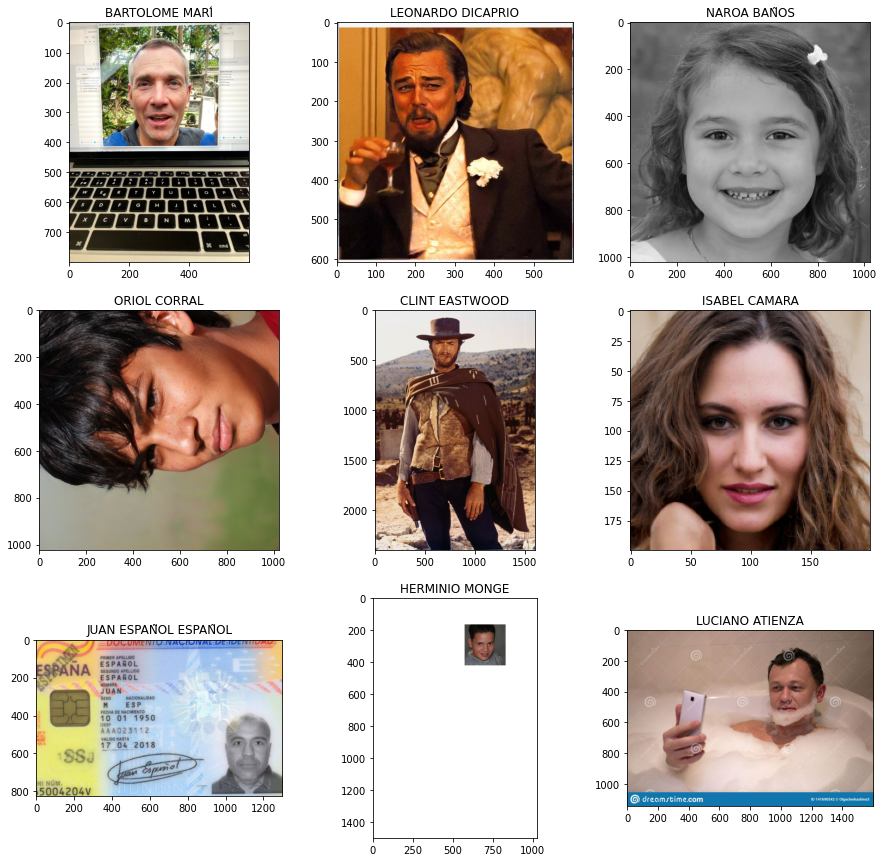

In [12]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(imgs, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# Paso 2: quitar fondo

<img src="https://raw.githubusercontent.com/ZHKKKe/MODNet/develop/doc/gif/image_matting_demo.gif">

Vamos a usar la librería [MODNet](https://github.com/ZHKKKe/MODNet) que sirve para eliminar el fondo sin necesidad de un chroma: para una imagen dada, nos devuelve una máscara del mismo tamaño donde cada píxel de la máscara indica si el píxel de la foto original pertenece al sujeto o al fondo.

In [13]:
if (temp_d / 'masks').exists():
    shutil.rmtree(temp_d / 'masks')
(temp_d / 'masks').mkdir()

In [14]:
# clone the repository
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt


/space/ml/demo_orla/MODNet


In [15]:
!python -m demo.image_matting.colab.inference \
        --input-path ../temp/alumnos \
        --output-path ../temp/masks \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt

Process image: BARTOLOME MARÍ.jpg
/home/javi/anaconda3/envs/tiltnet/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
Process image: LEONARDO DICAPRIO.jpg
Process image: NAROA BAÑOS.jpg
Process image: ORIOL CORRAL.jpg
Process image: CLINT EASTWOOD.jpg
Process image: ISABEL CAMARA.jpg
Process image: JUAN ESPAÑOL ESPAÑOL.jpg
Process image: HERMINIO MONGE.jpg
Process image: LUCIANO ATIENZA.jpg


In [16]:
%cd ..

/space/ml/demo_orla


In [17]:
(temp_d / 'masks').ls()

(#9) [Path('temp/masks/BARTOLOME MARÍ.png'),Path('temp/masks/LEONARDO DICAPRIO.png'),Path('temp/masks/NAROA BAÑOS.png'),Path('temp/masks/ORIOL CORRAL.png'),Path('temp/masks/CLINT EASTWOOD.png'),Path('temp/masks/ISABEL CAMARA.png'),Path('temp/masks/JUAN ESPAÑOL ESPAÑOL.png'),Path('temp/masks/HERMINIO MONGE.png'),Path('temp/masks/LUCIANO ATIENZA.png')]

In [18]:
masks = [ np.array(Image.open(p)) for p in (temp_d / 'masks').ls() ]

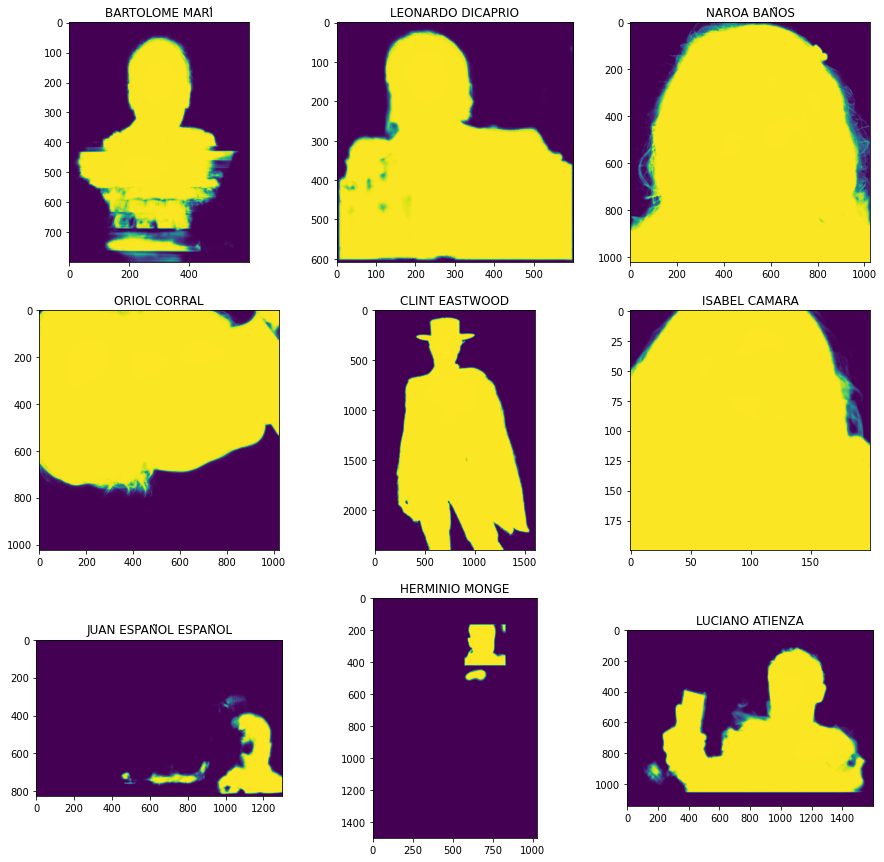

In [19]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(masks, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

In [20]:
imgs_nobg = []

for img, mask in zip(imgs, masks):
    white = np.full_like(img, 255)
    mask = mask[:,:,None].astype(np.float32) / 255
    img_nobg = ((img * mask) + white * (1-mask)).astype(np.uint8)
    #img_nobg.putalpha(Image.fromarray(mask))
    imgs_nobg.append(img_nobg)

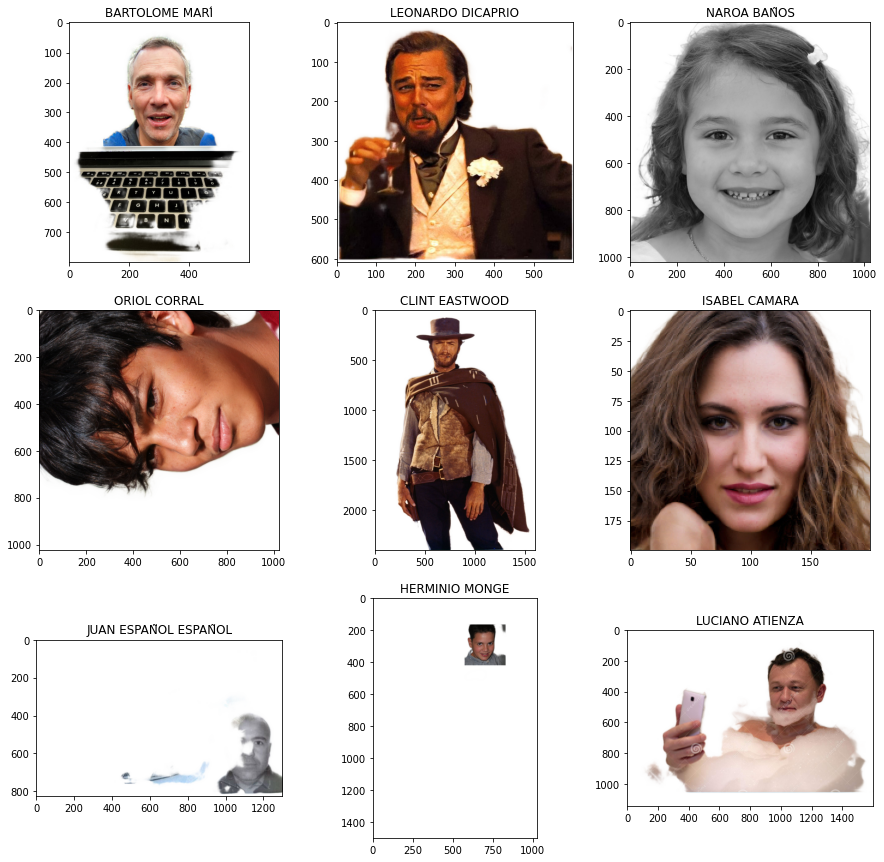

In [21]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(imgs_nobg, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# Paso 2: detección de caras

<img src="https://github.com/jamarju/demo_orla/raw/master/img/selfie_demo.png">

Para detectar las caras de una imagen vamos a usar el detector S3FD, uno de los mejores actualmente.

In [22]:
det = S3FD(device='cuda')

[S3FD] loading with cuda
[S3FD] finished loading (0.9889 sec)


In [23]:
bboxes_l = []
boxed_imgs = []
crops = []
crops_nopad = []

for img, img_nobg in tqdm(zip(imgs, imgs_nobg)):
    bboxes = det.detect_faces(img, conf_th=0.9)
    boxed_img = draw_bboxes(img, bboxes)
    crop, _ = crop_thumbnail(img_nobg, bboxes[0], padding=0.7, size=1024)
    crop_nopad, _ = crop_thumbnail(img, bboxes[0], padding=0.5, size=128)
    bboxes_l.append(bboxes)
    boxed_imgs.append(boxed_img)
    crops.append(crop)
    crops_nopad.append(crop_nopad)


0it [00:00, ?it/s]

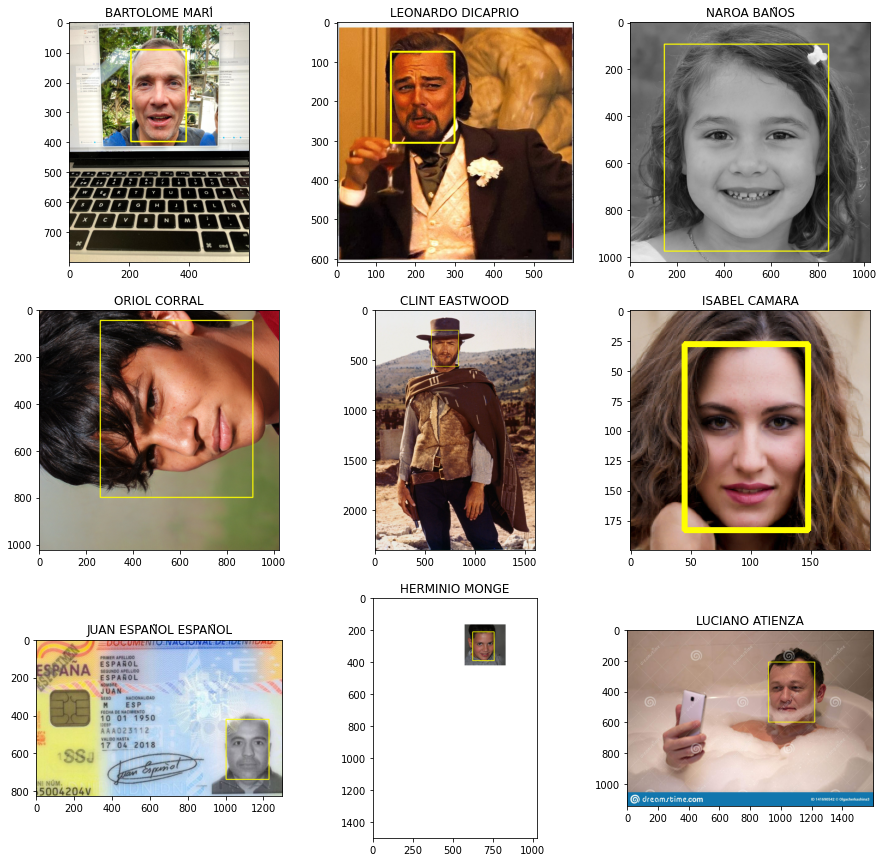

In [24]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(boxed_imgs, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

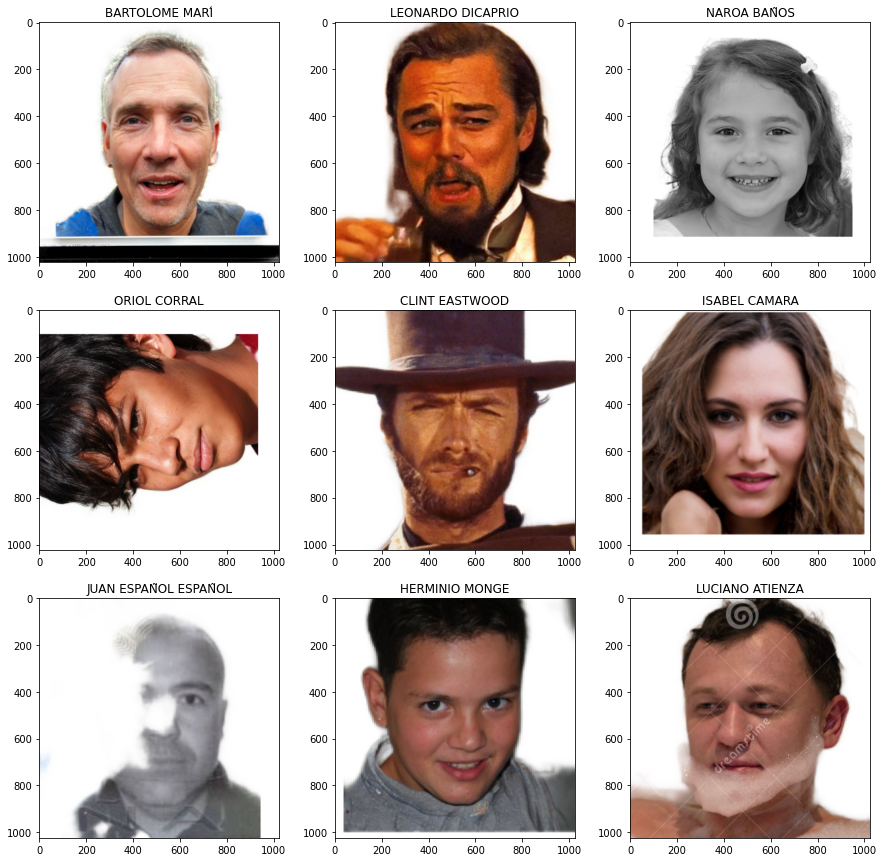

In [25]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(crops, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

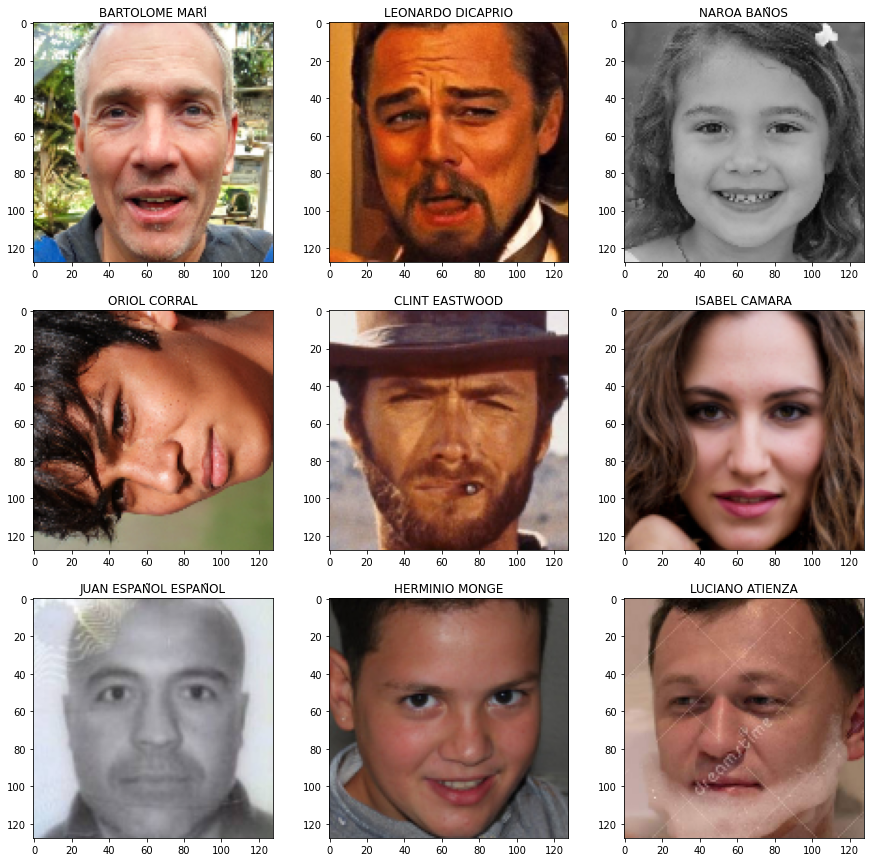

In [26]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(crops_nopad, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# Paso 3: rectificar orientación
En este paso usaremos... ¡la red neuronal que hemos entrenado nosotros mismos en el anterior cuaderno!

In [27]:
tiltnet = load_learner(data_d / 'tiltnet18.pkl', cpu=False)

In [28]:
tiltnet.predict(crops_nopad[2])

('0', tensor(0), tensor([9.9998e-01, 1.7714e-05, 3.3604e-08, 8.7058e-08]))

In [29]:
tiltnet.predict(crops_nopad[6])

('0', tensor(0), tensor([1.0000e+00, 1.2585e-07, 3.5421e-08, 2.7031e-08]))

In [30]:
str_crops = []

for crop, crop_nopad in tqdm(zip(crops, crops_nopad)):
    ori, _, _ = tiltnet.predict(crop_nopad)
    str_crop = np.array(Image.fromarray(crop).rotate(int(ori)))
    str_crops.append(str_crop)

0it [00:00, ?it/s]

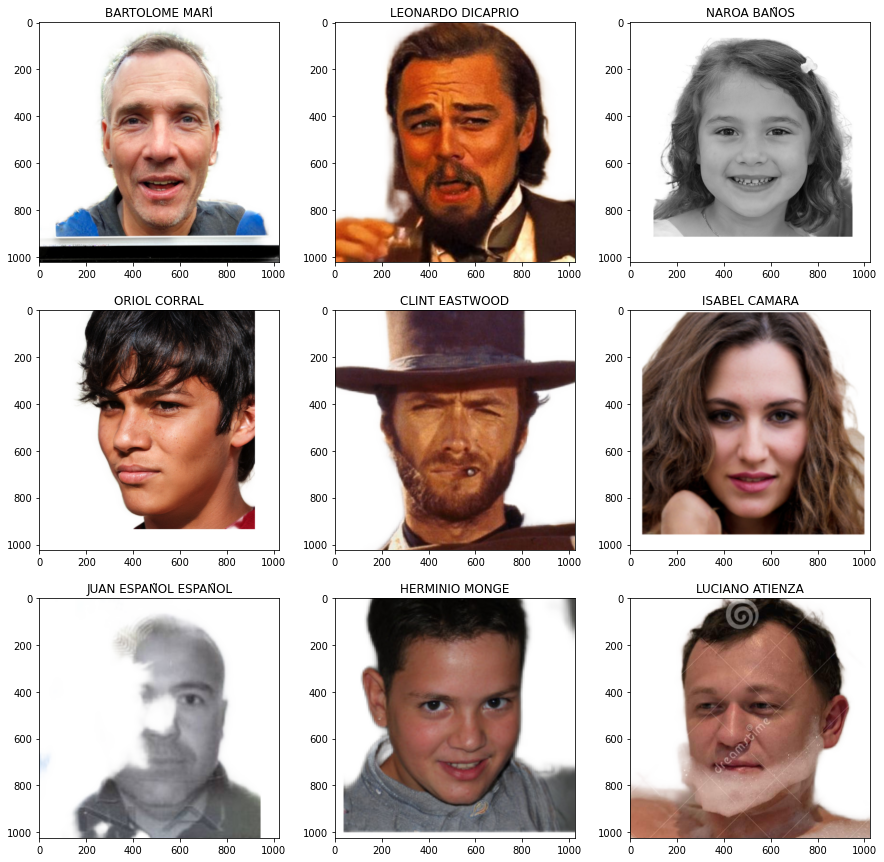

In [31]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(str_crops, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# ¡FIN!

Solo quedaría guardar las imágenes recortadas

In [32]:
(temp_d / 'out').mkdir(exist_ok=True)

for img, name in zip(str_crops, names):
    Image.fromarray(img).save(temp_d / 'out' / f'{name}.jpg')